## Import necessary libraries

In [13]:
import pandas as pd
import numpy as np
from graph_tool.all import *

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

## Optional: set number of threads

In [2]:
openmp_set_num_threads(6)
openmp_get_num_threads()

6

## Create graph from txt files

In [ ]:
nodes = {}
outliers = ["Forest\n", "Plains\n", "Island\n", "Mountain\n", "Swamp\n"]
current_deck = np.full(shape = 110, fill_value = -1)
g = Graph(directed = False)
eweight = g.new_ep("int32_t")
vcount  = g.new_vp("int32_t")
vname   = g.new_vp("string")

for i in range(100):
    file = str(i) + ".txt"
    print("Reading file " + file)
    graphfile = open(file)
    count = 0
    for line in graphfile:
        if line != "\n":
            if line in outliers:
                continue
            if line not in nodes:
                v = g.add_vertex()
                vcount[v] = 1
                vname[v]  = line.rstrip()
                nodes[line] = g.vertex_index[v]
            else:
                vcount[g.vertex(nodes[line])] = vcount[g.vertex(nodes[line])] + 1
            current_deck[count] = nodes[line]
            count = count + 1
        else:
            j = 0
            while current_deck[j] != -1:
                k = j + 1
                while current_deck[k] != -1:
                    e = g.edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
                    if (e == None):
                        e = g.add_edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
                        eweight[e] = 1
                    else:
                        eweight[e] = eweight[e] + 1
                    k = k + 1
                j = j + 1
            # Reset current deck and count
            current_deck = np.full(shape = 110, fill_value = -1)
            count = 0
    j = 0
    while current_deck[j] != -1:
        k = j + 1
        while current_deck[k] != -1:
            e = g.edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
            if (e == None):
                e = g.add_edge(g.vertex(current_deck[j]), g.vertex(current_deck[k]))
                eweight[e] = 1
            else:
                eweight[e] = eweight[e] + 1
            k = k + 1
        j = j + 1
    # Reset current deck and count
    current_deck = np.full(shape = 110, fill_value = -1)
    #print(nodes)
    #print(current_deck)
    graphfile.close()

## Save properties inside the graph object

In [55]:
g.vp["vName"]   = vname
g.vp["vCount"]  = vcount
g.ep["eWeight"] = eweight.copy(value_type="double")

## Normalize data according to M

In [93]:
maxWeight = np.max(g.ep["eWeight"].a)
eWeightMNorm = g.ep["eWeight"].copy(value_type="double").t(lambda x: maxWeight + 1 - x)
g.ep["eWeightMNorm"] = eWeightMNorm

## Normalize weights by inversion

In [94]:
eWeightInvNorm = g.ep["eWeight"].copy(value_type="double").t(lambda x: 1.0 / x)
g.ep["eWeightInvNorm"] = eWeightInvNorm

## Normalize by bringing mean close to zero and standard deviation to 1

In [38]:
arrayWeights = g.ep["eWeight"].get_array()
mean         = np.mean(arrayWeights)
std          = np.std(arrayWeights)
eWeightZ     = g.ep["eWeight"].copy(value_type="double").t(lambda x: (x - mean) / std)
#g.ep["eWeightZ"] = eWeightZ

## 0-1 Normalization

In [34]:
min_val = min(g.ep["eWeight"].a)
max_val = max(g.ep["eWeight"].a)
if max_val > min_val:
    eWeightMaxMin   = g.new_ep("double")
    eWeightMaxMin.a = (g.ep["eWeight"].a - min_val) / (max_val - min_val)
else:
    eWeightMaxMin   = g.ep["eWeight"].copy(value_type="double")

#g.ep["eWeightMaxMin"] = eWeightMaxMin

## Saving and loading graph from file

In [32]:
g.save("graph.gt", fmt='gt')

In [3]:
g = Graph(directed = False)
g.load("graph.gt")

## Print the list of properties stored inside the graph

In [4]:
print(g.list_properties())

vBetweennessClassic     (vertex)  (type: double)
vBetweennessInvNorm     (vertex)  (type: double)
vBetweennessMNorm       (vertex)  (type: double)
vClosenessClassic       (vertex)  (type: double)
vClosenessInvNorm       (vertex)  (type: double)
vClosenessMNorm         (vertex)  (type: double)
vCount                  (vertex)  (type: int32_t)
vName                   (vertex)  (type: string)
vPagerankClassic        (vertex)  (type: double)
vPagerankInvNorm        (vertex)  (type: double)
vPagerankMNorm          (vertex)  (type: double)
eWeight                 (edge)    (type: int32_t)
eWeightInvNorm          (edge)    (type: double)
eWeightMNorm            (edge)    (type: double)
None


## Draw graph and print number of vertices and edges

In [ ]:
graph_draw(g, output="graph.png")

print("The number of nodes is " + str(g.num_vertices()))
print("The number of edges is " + str(g.num_edges()))

## Compute node positions

In [ ]:
#pos = sfdp_layout(g)
pos = sfdp_layout(g, eweight=g.ep["eWeight"])

In [ ]:
g.vp["pos"] = pos

In [ ]:
graph_draw(g, pos=g.vp["pos"], output="graph.png")

## Betweenness

In [58]:
vBetweennessClassic, eBetweennessClassic = betweenness(
    g, weight=g.ep["eWeight"])

In [ ]:
g.vp["vBetweennessClassic"] = vBetweennessClassic

In [9]:
vBetweennessMNorm, eBetweennessMNorm = betweenness(
    g, weight=g.ep["eWeightMNorm"])

In [10]:
g.vp["vBetweennessMNorm"] = vBetweennessMNorm

In [ ]:
vBetweennessInvNorm, eBetweennessInvNorm = betweenness(
    g, weight=g.ep["eWeightInvNorm"])

In [90]:
g.vp["vBetweennessInvNorm"] = vBetweennessInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(vb, 0, 1, power=.1),
#           vertex_size=prop_to_size(vb, 1, 12, power=.2), vorder=vb,
#           output="betweenness.png")

## PageRank metric

In [59]:
vPagerankClassic = pagerank(g, weight = g.ep["eWeight"])

In [ ]:
g.vp["vPagerankClassic"] = vPagerankClassic

In [14]:
vPagerankMNorm = pagerank(g, weight=g.ep["eWeightMNorm"])

In [15]:
g.vp["vPagerankMNorm"] = vPagerankMNorm

In [18]:
vPagerankInvNorm = pagerank(g, weight=g.ep["eWeightInvNorm"])

In [19]:
g.vp["vPagerankInvNorm"] = vPagerankInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(pr, 0, 1, power=.1),
#           vertex_size=prop_to_size(pr, 1, 12, power=.2), vorder=pr,
#           output="pagerank.png") # 7 minutes

## Closeness

In [60]:
vClosenessClassic = closeness(g, weight=g.ep["eWeight"]) # 12 minutes

In [ ]:
g.vp["vClosenessClassic"] = vClosenessClassic

In [7]:
vClosenessMNorm = closeness(g, weight=g.ep["eWeightMNorm"])

In [8]:
g.vp["vClosenessMNorm"] = vClosenessMNorm

In [87]:
vClosenessInvNorm = closeness(g, weight=g.ep["eWeightInvNorm"])

In [88]:
g.vp["vClosenessInvNorm"] = vClosenessInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(c, 0, 1, power=.1),
#           vertex_size=prop_to_size(c, 1, 12, power=.2), vorder=c,
#           output="closeness.png")

## Local clustering coefficients

In [29]:
vLocClusteringClassic = local_clustering(g, weight=g.ep["eWeight"])

In [30]:
g.vp["vLocClusteringClassic"] = vLocClusteringClassic

In [ ]:
vLocClusteringMNorm = local_clustering(g, weight=g.ep["eWeightMNorm"])

In [ ]:
g.vp["vLocClusteringMNorm"] = vLocClusteringMNorm

In [25]:
vLocClusteringInvNorm = local_clustering(g, weight=g.ep["eWeightInvNorm"])

In [26]:
g.vp["vLocClusteringInvNorm"] = vLocClusteringInvNorm

In [ ]:
#graph_draw(g, pos=g.vp["pos"], vertex_fill_color=prop_to_size(vCl, 0, 1, power=.1),
#           vertex_size=prop_to_size(vCl, 1, 12, power=.2), vorder=vCl,
#           output="loc_clustering.png")

## Export betweenness and closeness to csv file

In [ ]:
betweenness = g.vp["vBetweennessClassic"].get_array()
closeness = g.vp["vClosenessClassic"].get_array()

In [ ]:
d = {'betweenness': betweenness, 'closeness': closeness}
df = pd.DataFrame(data=d)
MyMatrix = df.to_numpy()

In [ ]:
df.to_csv("out.csv")

## Print 20 of the cards with the highest score

In [33]:
closeness_array = g.vp["vLocClusteringClassic"].get_array()
kth = -20
ind = np.argpartition(closeness_array, kth)[kth:]
print([g.vp["vName"][index] for index in ind])

['Brightmare', 'Inspiring Unicorn', 'Daybreak Charger', 'Noble Quarry', 'Mesa Unicorn', 'Valorous Steed', 'Neighborhood Guardian', 'Ethereal Champion', 'Return to the Earth', 'Auriok Salvagers', 'Mountain Bandit', 'Lightfoot Rogue', 'Sphinx of the Chimes', 'Search the City', 'Crimson Kobolds', 'Crookshank Kobolds', 'Circu, Dimir Lobotomist', 'Manipulate Fate', 'Polluted Delta', 'Extract']


## Embedding and Clustering

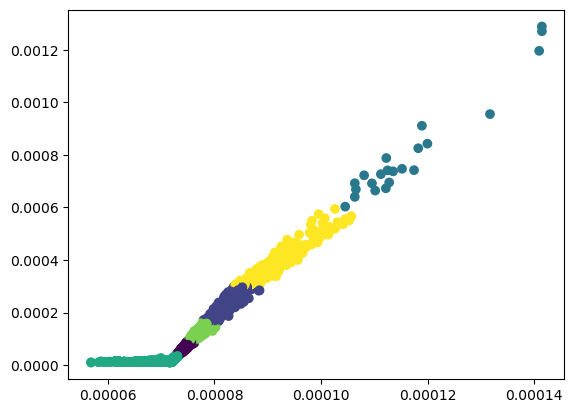

In [15]:
closeness_array = g.vp["vClosenessMNorm"].get_array()
pagerank_array = g.vp["vPagerankMNorm"].get_array()

embedding_points = np.transpose(np.vstack((closeness_array, pagerank_array)))

k = 6
pred = KMeans(n_clusters=k).fit_predict(embedding_points)

plt.scatter(embedding_points[:, 0], embedding_points[:, 1], c=pred)
plt.show()

In [19]:
# get some random samples for each cluster
_, clust_indexes, clust_sizes = np.unique(pred, return_index=True, return_counts=True)
print(clust_sizes)

for i in range(0, k):
    print(f"=====>Cluster {i}, size {clust_sizes[i]}")

    cluster_node_indices = np.where(pred == i)[0]
    
    cards_in_cluster = [g.vp["vName"][random.choice(cluster_node_indices)] for _ in range(0, 20)]
    cards_in_cluster.sort()

    query = ""
    for name in cards_in_cluster:
        query += f"!\"{name}\" or "
    print(query.removesuffix(" or "))

[ 4342   779    22 11393  1877   234]
=====>Cluster 0, size 4342
!"Charming Prince" or !"Corpse Churn" or !"Dawntreader Elk" or !"Eternal Skylord" or !"Evangel of Heliod" or !"Fae Flight" or !"Feywild Visitor" or !"Heartstone" or !"Liliana's Contract" or !"Magus of the Moon" or !"Master of Ceremonies" or !"Mausoleum Wanderer" or !"Niambi, Esteemed Speaker" or !"Not of This World" or !"Omo, Queen of Vesuva" or !"Sadistic Shell Game" or !"Sivitri, Dragon Master" or !"Spirit Mantle" or !"Wildwood Scourge" or !"Winter, Cynical Opportunist"
=====>Cluster 1, size 779
!"Akroma's Memorial" or !"Aura Shards" or !"Beledros Witherbloom" or !"Disallow" or !"Fist of Suns" or !"Gloomlake Verge" or !"Minas Tirith" or !"Mirror Entity" or !"Moldervine Reclamation" or !"Mystic Sanctuary" or !"Obscura Storefront" or !"Pongify" or !"Pyroblast" or !"Reflections of Littjara" or !"Rune-Scarred Demon" or !"Seat of the Synod" or !"Shire Terrace" or !"Surge of Salvation" or !"Talisman of Unity" or !"Wear // Tea

## Diameter

In [21]:
source = 13848
diam, (card1, card2) = pseudo_diameter(g, source=source, weights=g.ep["eWeightMNorm"])
print(diam, g.vp["vName"][card1], g.vp["vName"][card2])

20868.0 Skyclave Squid +2 Mace
